In [2]:
import os,math, imutils, cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:

#Base class which will contains the methods for Shape detection, currently it supports Checkboxes and Radio Buttons
class ShapeFinder():
    
    #constructor
    def __init__(self):
        pass
                   
    #read the image(s) and store in an array
    def get_images(self,dirname,checkbox = True, radio_bt = True,rec_max_area = 5000, rec_min_area = 300, blocksize = 19, thresh_const = 3,epsilon = .055, aspect_ratio = (.85,1.2),kernelsize = (3,3),hough_param1 = 30,hough_param2 = 25):
        
        #initialize variables
        self.dirname = dirname
        self.rec_max_area = rec_max_area
        self.rec_min_area = rec_min_area
        self.blocksize = blocksize 
        self.thresh_const = thresh_const
        self.epsilon = epsilon
        self.kernelsize = kernelsize
        self.checkbox = checkbox
        self.radio_bt = radio_bt
        self.aspect_ratio = aspect_ratio
        self.extracted_img_data = []
        self.hough_param1 = hough_param1
        self.hough_param2 = hough_param2        
        image_arr = []
        name_arr = []
        
        try:
            #loop through each object in the directory
            for x in os.listdir(self.dirname):

                if os.path.isdir(os.path.join(dirname,x)) == False:

                    #supported formats
                    if (x.split('.')[1].lower()) in ('png','jpg','jpeg'):
                        img_filename = x
                        
                        #img = matplotlib.image.imread(os.path.join(dirname,img_filename))
                        img =cv2.imread(os.path.join(dirname,img_filename),cv2.IMREAD_COLOR)

                        #convert image pixels within range 0-255
                        img = cv2.normalize(src=img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

                        image_arr.append(np.array(img))
                        name_arr.append(img_filename)
        
        except Exception as e:            
            print('The following exception occured during image fetch: ',e) 

        if self.radio_bt == True:
            self.extract_circles(image_arr,name_arr)        

        if self.checkbox == True:
            self.extract_quads(image_arr,name_arr)
                   
        
        return self.extracted_img_data
    
    #image processing for quadrilateral shapes
    def do_quad_imageprocessing(self,gray,block_size,tc,kernelsize):
        
        try:
            #thresholding
            th2 = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,block_size,tc) 

            #remove background
            fgbg = cv2.createBackgroundSubtractorMOG2()
            fgmask = fgbg.apply(th2)
            thresh2 = cv2.adaptiveThreshold(fgmask,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,block_size,tc)

            #image dilation
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernelsize[0],kernelsize[1]))
            img_dilate = cv2.dilate(thresh2.copy(), kernel,iterations = 1)        
        
        except Exception as e:
            print('The following exception occured during image preprocessing: ',e)
            img_dilate = []

        return img_dilate  
     
    #detect circles
    def extract_circles(self,image_arr,name_arr):
               
        #loop through each image    
        for index,orig_img in enumerate(image_arr):            
            
            extracted_circles = []
            img = orig_img.copy()
            
            try:
                #grayscale only if its not already
                if len(img.shape) > 2: 
                    gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
                else:
                    gray = img.copy()

                height,width = np.array(gray).shape
                mask = np.zeros((height,width), np.uint8)

                #used bilateral but other blurring methods can also be explored
                blur_img = cv2.bilateralFilter(gray,15,42,61) 
                detected_circles = cv2.HoughCircles(blur_img, cv2.HOUGH_GRADIENT, 1, 20, param1 = self.hough_param1 , param2 = self.hough_param2, minRadius = 1, maxRadius = 40) 

                # Draw circles that are detected. 
                if detected_circles is not None: 

                    # Convert the circle parameters a, b and r to integers. 
                    detected_circles = np.uint16(np.around(detected_circles)) 

                    for pt in detected_circles[0, :]: 
                        a, b, r = pt[0], pt[1], pt[2] 
                        area = (math.pi*r*r)

                        if area > 100:
                            # Draw the circumference of the circle. 
                            cv2.circle(img, (a, b), r, (0,255, 0), 2) 
                            circle_img = cv2.circle(mask,(a,b),r,(255,255,255),thickness=-1)      

                    # Copy the image using that mask
                    masked_data = cv2.bitwise_and(orig_img, orig_img, mask=mask)

                    # Apply Threshold
                    _,thresh = cv2.threshold(mask,1,255,cv2.THRESH_BINARY)

                    # Find Contour
                    contours = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
                    contours = imutils.grab_contours(contours)

                    for c in contours:
                        peri = cv2.arcLength(c, True)
                        approx = cv2.approxPolyDP(c, (.055)* peri, True)

                        #bounding rec cordinates
                        (x, y, w, h) = cv2.boundingRect(approx)

                        # Crop masked_data
                        crop = masked_data[y:y+h,x:x+w]

                        #save the extracted radio buttons/circles
                        extracted_circles.append(crop)
                        
            except Exception as e:
                print('The following exception occured during circle shape detection: ',e)

            #save the original image with highlighted circles in the same folder 
            self.extracted_img_data.append([img,extracted_circles,name_arr[index]])
                                           
           
    #detect checkbox/square
    def extract_quads(self,image_arr,name_arr):
                     
        if len(image_arr) > 0:
        
            for index,original_image in enumerate(image_arr):
                
                #to store extracted images
                extracted_quad = []
                image = original_image.copy()          

                #grayscale only if its not already
                if len(image.shape) > 2:
                    gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)  
                else:
                    gray = image.copy()

                #image preprocessing for quadrilaterals
                img_dilate = self.do_quad_imageprocessing(gray,self.blocksize,self.thresh_const,self.kernelsize)   

                if len(img_dilate) > 0:

                    try:
                        #detect contours
                        cnts = cv2.findContours(img_dilate.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
                        cnts = imutils.grab_contours(cnts)

                        #loop through detected contours
                        for c in cnts:
                            peri = cv2.arcLength(c, True)
                            approx = cv2.approxPolyDP(c, (self.epsilon)* peri, True)

                            #bounding rec cordinates
                            (x, y, w, h) = cv2.boundingRect(approx)

                            #get the aspect ratio
                            aspectratio = float(w/h)
                            area = cv2.contourArea(c) 
                            if area < self.rec_max_area and area > self.rec_min_area and (aspectratio >= self.aspect_ratio[0] and aspectratio <= self.aspect_ratio[1]):

                                #check if there are 4 corners in the polygon
                                if len(approx) == 4:                 
                                    cv2.drawContours(original_image,[c], 0, (0,255,0), 2)
                                    roi = original_image[y:y+h, x:x+w]
                                    extracted_quad.append(roi)

                    except Exception as e:
                        print('The following exception occured during quad shape detection: ',e)
                        
                self.extracted_img_data.append([original_image,extracted_quad,name_arr[index]])
        
        else:            
            print('No image is found during the extraction process')
                
        

In [3]:
dirname = 'Checkbox Testing'

extracted_checkbox = ShapeFinder().get_images(dirname,checkbox = True, radio_bt = False,rec_max_area = 6000,rec_min_area = 300,blocksize = 19,
                                                thresh_const = 3,epsilon = .065,aspect_ratio = (.85,1.2),kernelsize = (3,3),
                                                hough_param1 = 30,hough_param2 = 25)


Image Name:  00000000.jpg


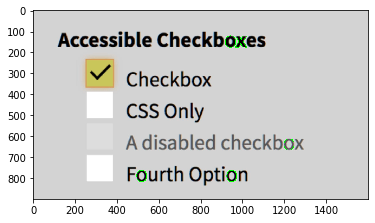

Detected Segments: 


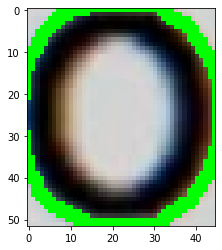

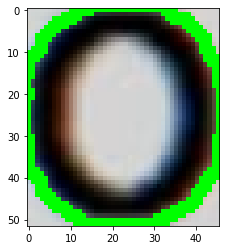

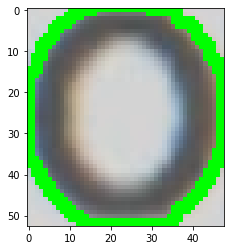

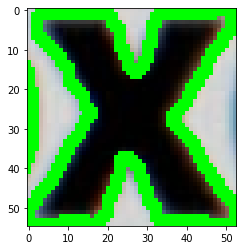

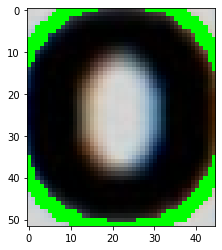

Image Name:  00000002.jpg


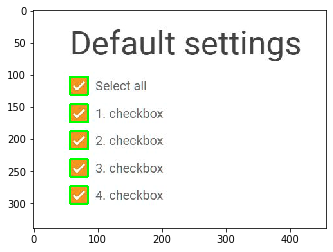

Detected Segments: 


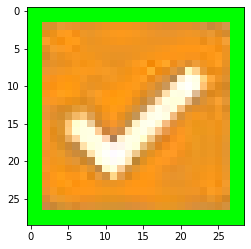

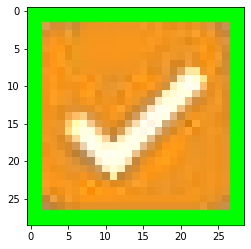

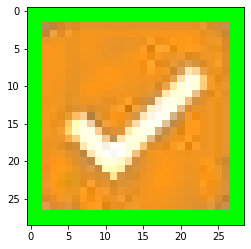

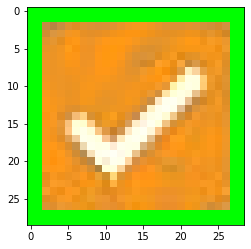

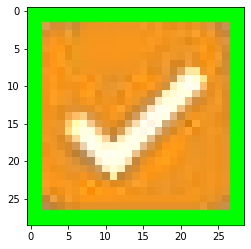

Image Name:  00000003.jpg


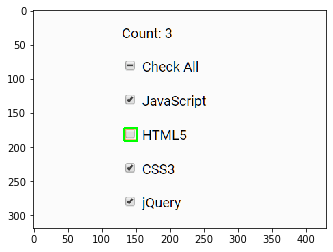

Detected Segments: 


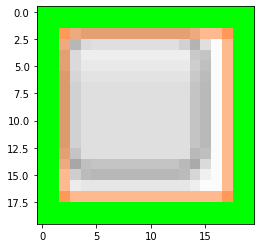

Image Name:  00000004.jpg


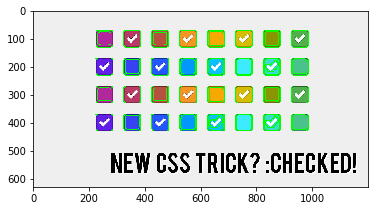

Detected Segments: 


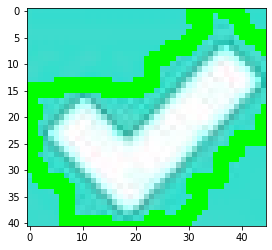

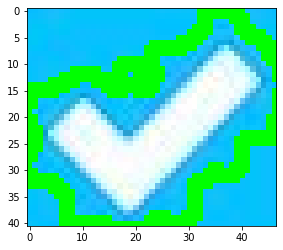

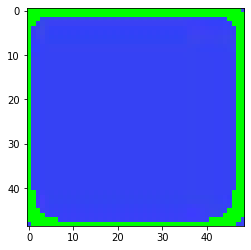

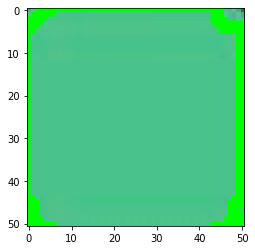

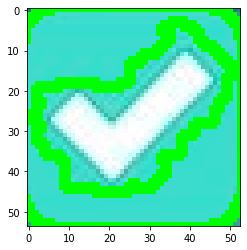

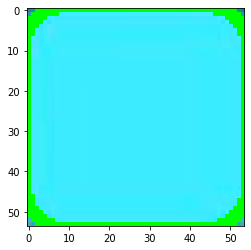

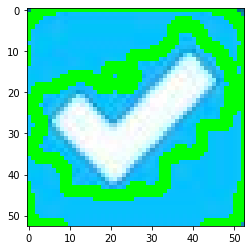

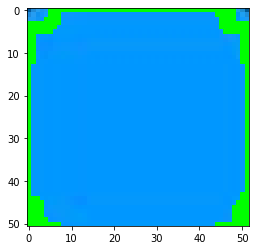

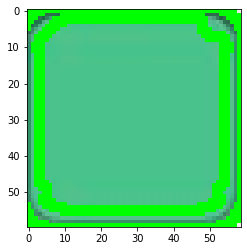

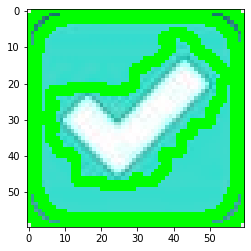

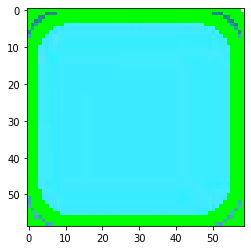

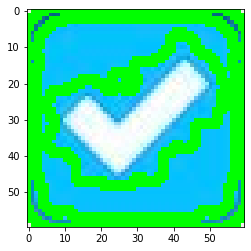

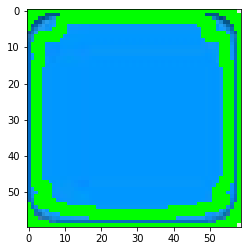

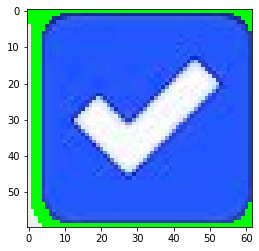

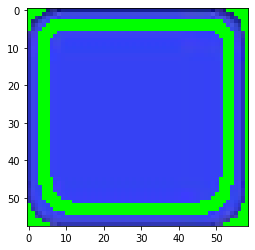

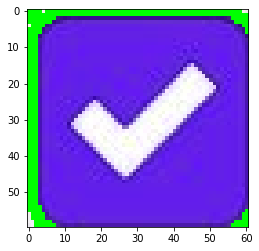

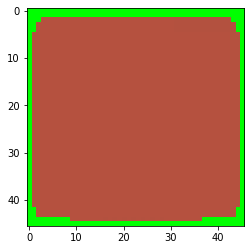

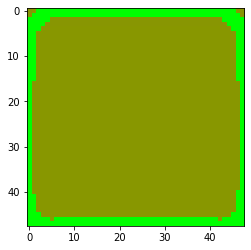

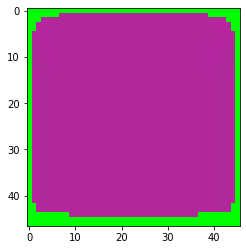

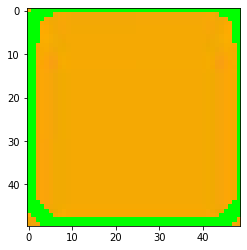

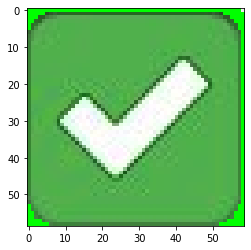

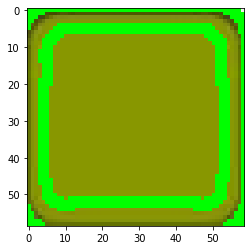

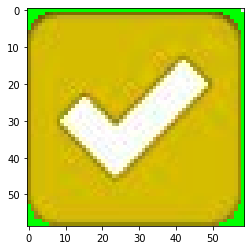

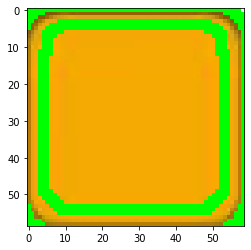

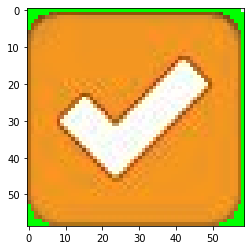

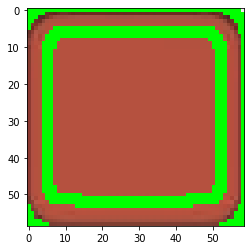

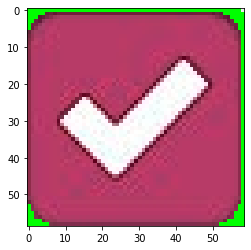

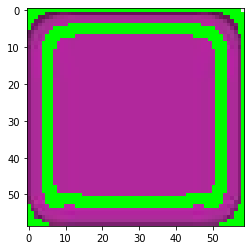

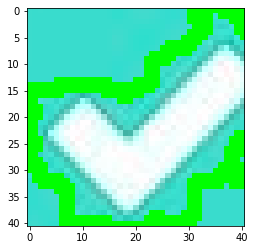

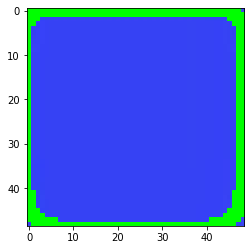

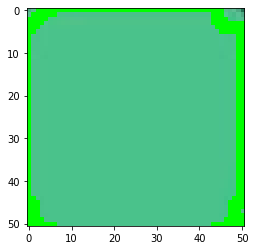

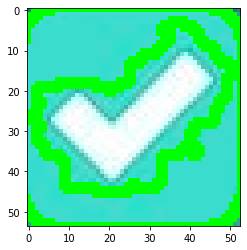

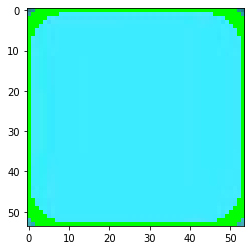

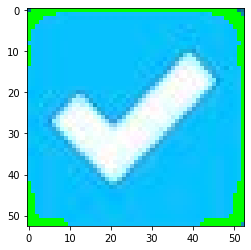

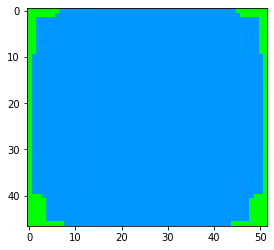

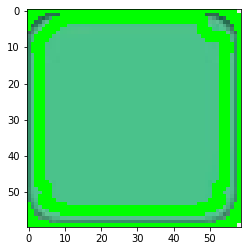

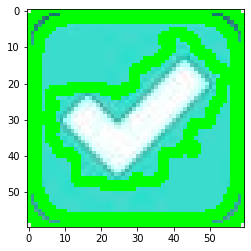

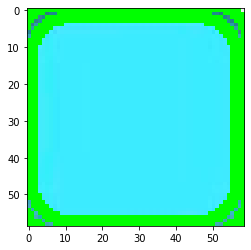

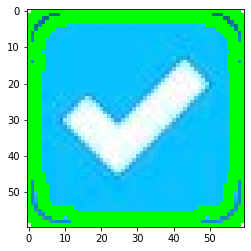

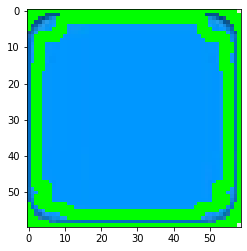

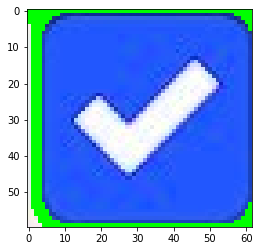

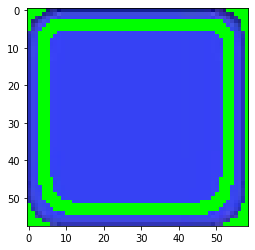

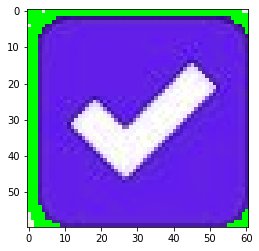

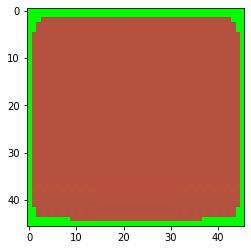

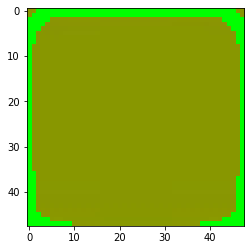

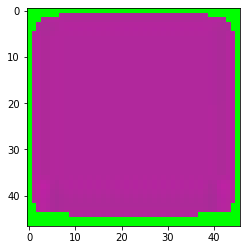

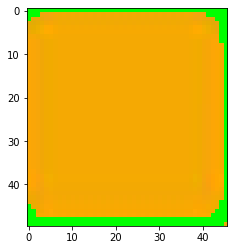

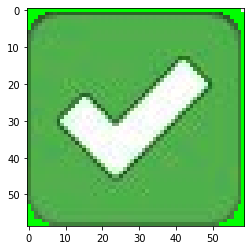

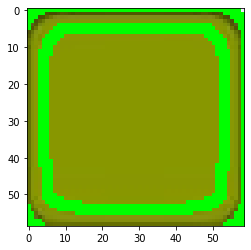

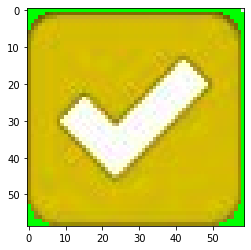

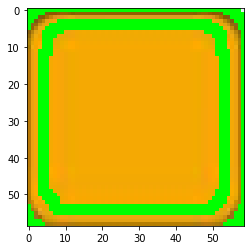

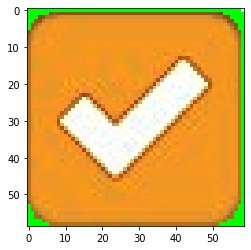

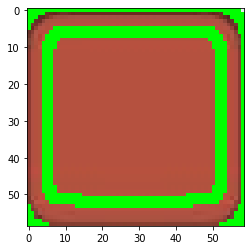

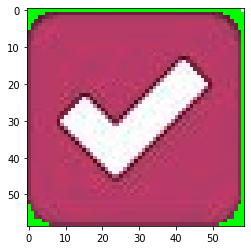

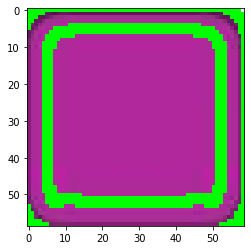

Image Name:  00000014.jpg


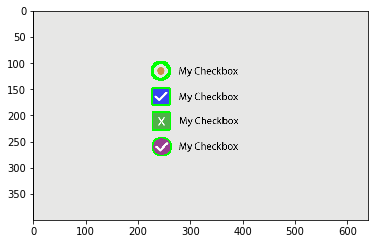

Detected Segments: 


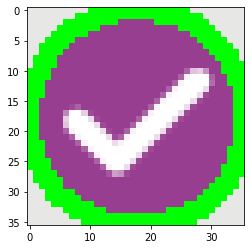

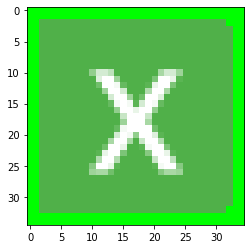

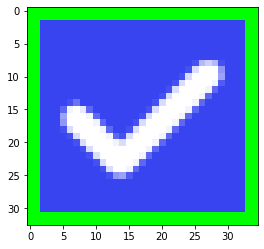

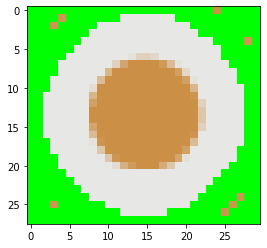

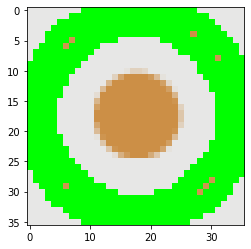

In [4]:
for x in (extracted_checkbox):
    print('Image Name: ', x[2])
    plt.imshow(x[0])
    plt.show()
    print('Detected Segments: ')
    for z in x[1]:
        plt.imshow(z)
        plt.show()

## Helper function to get the best parameters for a radio button detection

In [ ]:
dir = 'Radio Bt Testing'

def nothing(x):
    pass

# Create a black image, a window
cv2.namedWindow('image',cv2.WINDOW_NORMAL)

cv2.createTrackbar('a1', 'image', 15, 100, nothing)
cv2.createTrackbar('b1', 'image', 42, 100, nothing)
cv2.createTrackbar('c1', 'image', 61, 100, nothing)
cv2.createTrackbar('param1', 'image', 30, 100, nothing)
cv2.createTrackbar('param2', 'image', 25, 100, nothing)
cv2.createTrackbar('dp', 'image', 1, 10, nothing)
cv2.createTrackbar('mindist', 'image', 20, 100, nothing)

for x in os.listdir(dir):
    if os.path.isdir(x) == False:
        
        img_path = os.path.join(dir,(os.path.basename(x)))
       
        while(1):
           
            orig_img = cv2.imread(img_path,cv2.IMREAD_COLOR)         
            img = orig_img.copy()
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            a1 = cv2.getTrackbarPos('a1', 'image')
            b1 = cv2.getTrackbarPos('b1', 'image')
            c1 = cv2.getTrackbarPos('c1', 'image')
            param1 = cv2.getTrackbarPos('param1', 'image')
            param2 = cv2.getTrackbarPos('param2', 'image')
            dp = cv2.getTrackbarPos('dp', 'image')
            mindist = cv2.getTrackbarPos('mindist', 'image')

            k = cv2.waitKey(1) & 0xFF
            if k == 27:
                break

            blurred_img = cv2.bilateralFilter(gray,a1,b1,c1)                     
            detected_circles = cv2.HoughCircles(blurred_img, cv2.HOUGH_GRADIENT, dp, mindist, param1 = param1, param2 = param2, minRadius = 1, maxRadius = 40) 

        # Draw circles that are detected. 
            if detected_circles is not None: 

                # Convert the circle parameters a, b and r to integers. 
                detected_circles = np.uint16(np.around(detected_circles)) 

                for pt in detected_circles[0, :]: 
                    a, b, r = pt[0], pt[1], pt[2] 
                    area = (math.pi*r*r)

                    if area > 100:
                        
                        # Draw the circumference of the circle. 
                        cv2.circle(orig_img, (a, b), r, (0,255, 0), 2) 
                orig_img = cv2.imshow('image',orig_img)
            
    cv2.destroyAllWindows()